# ECCO Data - cleaned version
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.95:35191")
client

Client Scheduler: tcp://10.32.16.95:35191 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 19 Cores: 38 Memory: 218.50 GB


In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
%matplotlib inline
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
xr.set_options(display_style='text')

In [3]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()

In [4]:
ds_ll = faces_dataset_to_latlon(ds)

In [5]:
# a trick to make things work a bit faster
coords_before_drop = ds_ll.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds_before_drop = ds_ll.reset_coords(drop=True).roll(i=50, i_g=50)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
coords = coords_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])
ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [7]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row

In [27]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

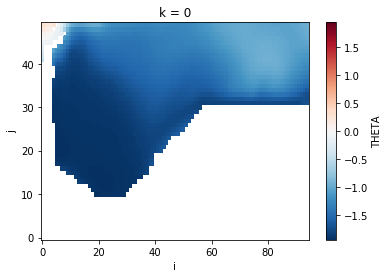

In [10]:
#testing to see if correctly sliced desired region
sst_mean = ds.THETA.sel(**lat_range, **lon_range).sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0)
sst_mean.where(surface_mask).plot()

## <span style='color:Brown'> Bottom Potential Temperatures

In [9]:
#this gives us the depth of the bottom cell
depth_max = ds.k.where(coords.hFacC > 0).max(dim='k').load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


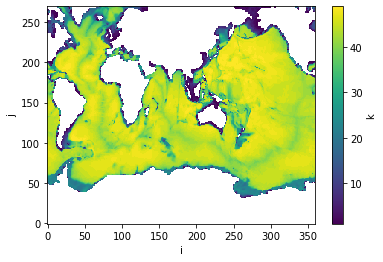

In [12]:
depth_max.plot()

In [10]:
bottom_temp = ds.THETA.isel(k=depth_max.fillna(0.).astype('i4'))
bottom_temp_wg = bottom_temp.isel(**lat_range, **lon_range).load()

In [15]:
bottom_temp_wg_mean = bottom_temp_wg.mean(dim='time').load()

In [30]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

In [11]:
bottom_temp_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_temp_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)

In [12]:
bottom_temp_wg.to_netcdf('/home/jovyan/WMT/ECCO-budgets/bottom_temp_wg.nc')

In [26]:
bottom_temp_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_temp_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)
bottom_temp_wg_mean

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5656109 ,  1.8291065 ,  1.6809775 , ..., -0.60746783,
        -0.60745776, -0.6074615 ],
       [ 0.13080378,  0.25096482,  1.8400244 , ..., -0.60863906,
        -0.6083164 , -0.608207  ],
       [ 0.12459682,  0.0798245 ,  0.19863093, ..., -0.61016595,
        -0.6093797 , -0.60912585]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67

In [28]:
lon = coords_before_drop.XC.isel(**lon_range, **lat_range)
lat = coords_before_drop.YC.isel(**lat_range, **lon_range)

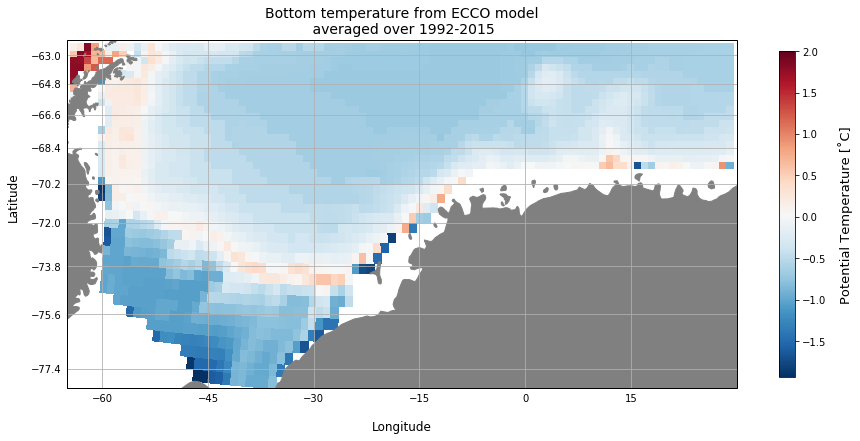

In [28]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_temp_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from ECCO model\n averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [29]:
bottom_std_temp = ds.THETA.isel(k=depth_max.fillna(0.).astype('i4')).std('time')
bottom_std_temp_wg = bottom_std_temp.isel(**lat_range, **lon_range)

In [30]:
bottom_std_temp_wg.load()

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07491323, 0.03105013, 0.08613247, ..., 0.02001635, 0.01984921,
        0.01967735],
       [0.10633206, 0.08333268, 0.0289332 , ..., 0.02005466, 0.01991507,
        0.01977147],
       [0.10318091, 0.11221348, 0.09422934, ..., 0.02019693, 0.02006324,
        0.0199395 ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
Dimensions without coordinates: j, i

In [31]:
bottom_std_temp_wg['j'] = coords_before_drop.j.isel(**lat_range)
bottom_std_temp_wg['i'] = coords_before_drop.i.isel(**lon_range)
bottom_std_temp_wg

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07491323, 0.03105013, 0.08613247, ..., 0.02001635, 0.01984921,
        0.01967735],
       [0.10633206, 0.08333268, 0.0289332 , ..., 0.02005466, 0.01991507,
        0.01977147],
       [0.10318091, 0.11221348, 0.09422934, ..., 0.02019693, 0.02006324,
        0.0199395 ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67

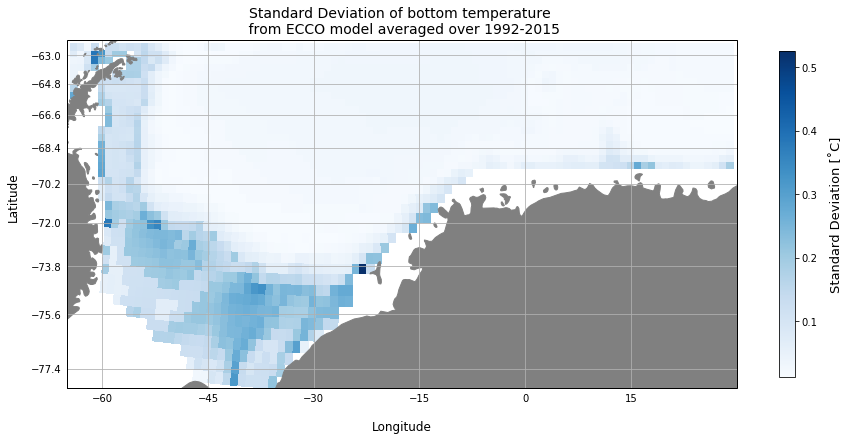

In [32]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_std_temp_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='Blues')
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom temperature \n from ECCO model averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Temperature Deviation (end)

## <span style='color:Red'> Bottom Temperature Z-score (start)

## Bottom Salinity

In [20]:
bottom_slt = ds.SALT.isel(k=depth_max.fillna(0.).astype('i4'))

In [21]:
bottom_slt_wg = bottom_slt.isel(**lat_range, **lon_range).load()

In [22]:
bottom_slt_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_slt_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)
bottom_slt_wg

<xarray.DataArray 'SALT' (time: 288, j: 50, i: 95)>
array([[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.708115, 34.682255, 34.660656, ..., 34.660717, 34.6605  ,
         34.660297],
        [34.701786, 34.704594, 34.6808  , ..., 34.66061 , 34.660397,
         34.6602  ],
        [34.701675, 34.700718, 34.703335, ..., 34.660534, 34.66032 ,
         34.66012 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.70819 , 34.682068, 34.66499 , ..., 34.66071 , 34.660492,
         34.660275],
        [34.70147 , 34.704384, 34.68081 , ..., 34.660618, 34.6604  ,
         34.660187],
        [34.701355, 34.700485, 34.70313 , ..., 34.660545, 34.660328,
         34.66012 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.708263, 34.68018 , 34.658672, ..., 34.660698, 34.660477,
         34.66026 ],
        [34.70134 , 34.704243, 34.679356, ..., 34.660618, 34.6604  ,
         34.660183],
        [34.70125 , 34.700294, 34.70295 , ..., 34.660553, 34.660336,
         34.660122]],

       ...,

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.716988, 34.68081 , 34.66339 , ..., 34.678368, 34.677933,
         34.67748 ],
        [34.708282, 34.710587, 34.6728  , ..., 34.678307, 34.677837,
         34.677353],
        [34.70816 , 34.706566, 34.70935 , ..., 34.67828 , 34.67779 ,
         34.677277]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.716976, 34.68437 , 34.66841 , ..., 34.67846 , 34.67804 ,
         34.677597],
        [34.70827 , 34.710537, 34.675945, ..., 34.678413, 34.677963,
         34.677498],
        [34.70809 , 34.706623, 34.70929 , ..., 34.6784  , 34.67792 ,
         34.67744 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.716938, 34.686474, 34.671482, ..., 34.67844 , 34.678024,
         34.677578],
        [34.7082  , 34.710506, 34.67907 , ..., 34.67842 , 34.677975,
         34.67752 ],
        [34.707985, 34.70662 , 34.709286, ..., 34.678436, 34.67797 ,
         34.6775  ]]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
Attributes:
    long_name:      Salinity
    standard_name:  SALT
    units:          psu

In [23]:
bottom_slt_wg.to_netcdf('bottom_slt_wg.nc')

In [24]:
bottom_slt_wg_mean = bottom_slt_wg.mean(dim='time').load()

In [25]:
bottom_slt_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_slt_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)
bottom_slt_wg_mean

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.712536, 34.676   , 34.642563, ..., 34.6691  , 34.668694,
        34.66834 ],
       [34.702305, 34.706024, 34.67171 , ..., 34.669205, 34.668774,
        34.66839 ],
       [34.702038, 34.700333, 34.704147, ..., 34.66935 , 34.668922,
        34.668484]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5

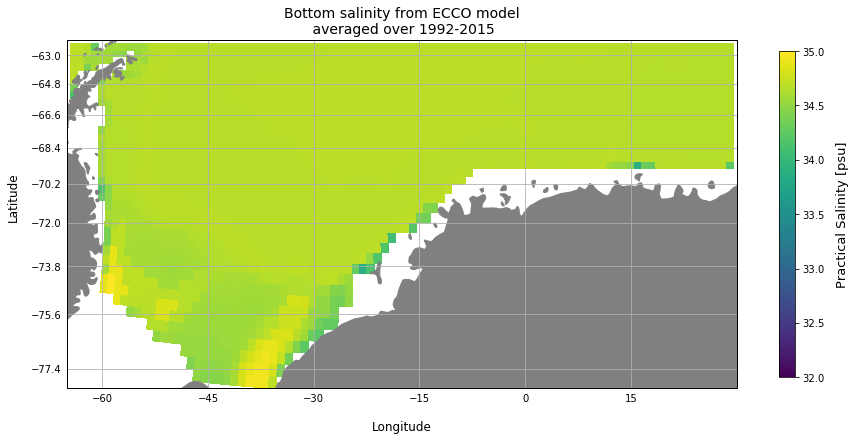

In [31]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_slt_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='viridis', vmin=32, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from ECCO model\n averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [32]:
bottom_std_slt = ds.SALT.isel(k=depth_max.fillna(0.).astype('i4')).std('time')
bottom_std_slt_wg = bottom_std_slt.isel(**lat_range, **lon_range)

In [34]:
bottom_std_slt_wg.load()

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00273975, 0.00564287, 0.01474723, ..., 0.00557772, 0.00552944,
        0.00547744],
       [0.00240092, 0.0022759 , 0.00506051, ..., 0.00562872, 0.0055671 ,
        0.00550446],
       [0.00243282, 0.00255845, 0.00248424, ..., 0.00568517, 0.00561054,
        0.00553797]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
Dimensions without coordinates: j, i

In [35]:
bottom_std_slt_wg['j'] = coords_before_drop.j.isel(**lat_range)
bottom_std_slt_wg['i'] = coords_before_drop.i.isel(**lon_range)
bottom_std_slt_wg

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00273975, 0.00564287, 0.01474723, ..., 0.00557772, 0.00552944,
        0.00547744],
       [0.00240092, 0.0022759 , 0.00506051, ..., 0.00562872, 0.0055671 ,
        0.00550446],
       [0.00243282, 0.00255845, 0.00248424, ..., 0.00568517, 0.00561054,
        0.00553797]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67

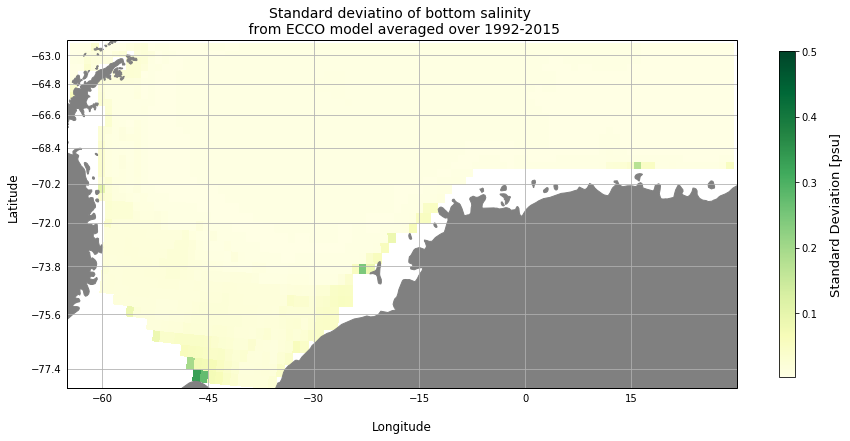

In [40]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_std_slt_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='YlGn', vmax=0.5)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviatino of bottom salinity \n from ECCO model averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity Z-score (start)

## <span style='color:Red'> Bottom Salinity Z-score (end)